<a href="https://colab.research.google.com/github/vijayshankarrealdeal/intro_to_pytorch-Gans/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
# Wasserstein GAN with Gradient Penalty

In [159]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [160]:
def show_tensor_images(image_tensor,num_images = 25,size = (1,28,28)):
  image_tensor = (image_tensor + 1)/2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images],nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [161]:
def make_grad_hook():
  grads = []
  def grad_hooks(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
      grads.append(m.weights.grad)
    
  return grads,grad_hooks


In [162]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


In [163]:
def get_noise(n_samples,z_dim,device = 'cpu'):
  return torch.randn(n_samples,z_dim,device = device)

In [164]:
class Critic(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [165]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [166]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

In [167]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [168]:

def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs= mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [169]:
def gradient_penalty(grad):
  grad_flat = grad.view(len(grad),-1)
  grad_norm = grad_flat.norm(2,dim = 1)
  penalty = torch.mean((grad_norm - 1)**2)
  return penalty

In [170]:
def get_gen_loss(crit_fake_pred):
  gen_loss = -1*torch.mean(crit_fake_pred)
  return gen_loss

In [171]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
  crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + gp*c_lambda
  return crit_loss

Step 50: Generator loss: -0.057635857936693353, critic loss: 1.649917831391096


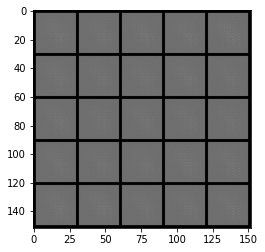

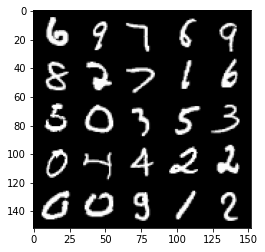

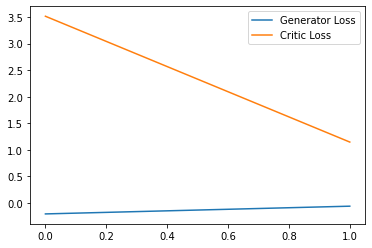

Step 100: Generator loss: 2.2178112983703615, critic loss: -4.058690575301647


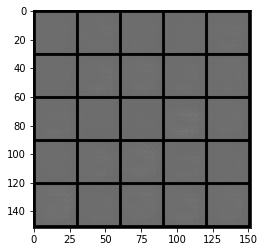

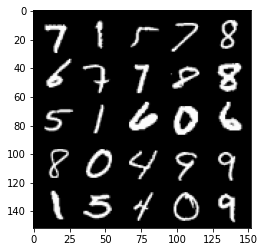

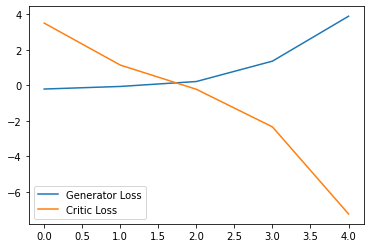

Step 150: Generator loss: 1.4236145746707916, critic loss: -12.409535541534424


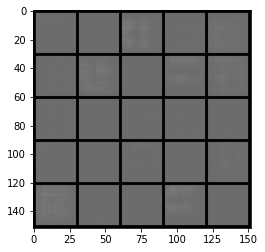

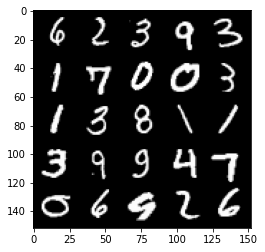

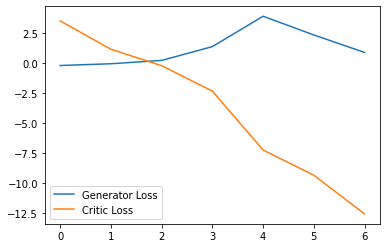

Step 200: Generator loss: 1.4119288218021393, critic loss: -32.012577865600576


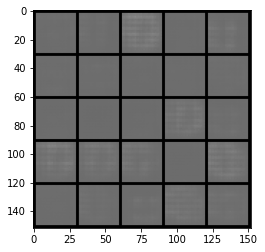

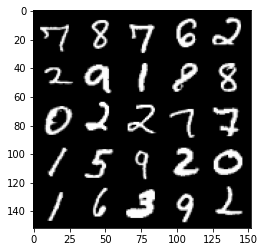

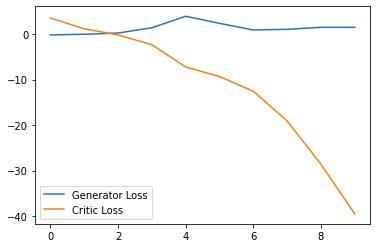

Step 250: Generator loss: 2.911292037963867, critic loss: -64.94331784057617


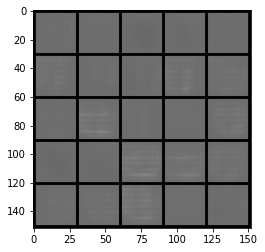

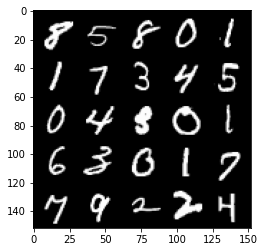

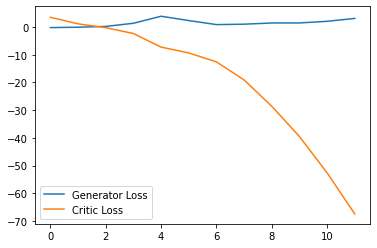

Step 300: Generator loss: 6.77714750289917, critic loss: -109.79522399902345


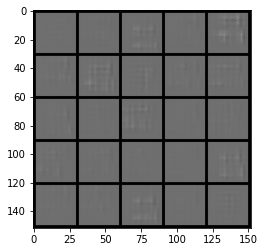

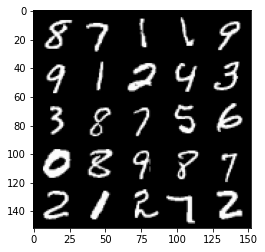

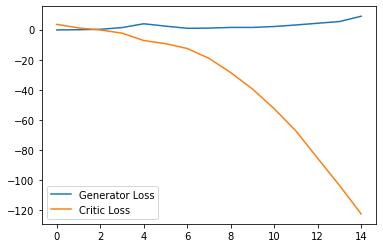

Step 350: Generator loss: 9.494272966384887, critic loss: -159.91404324340817


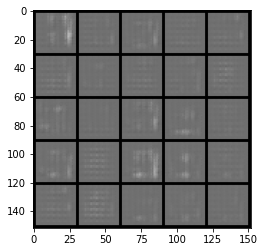

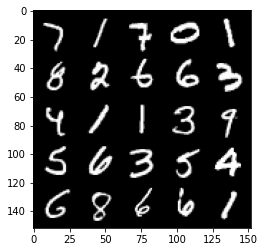

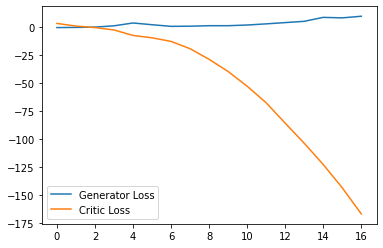

Step 400: Generator loss: 13.114921312332154, critic loss: -215.6761028137207


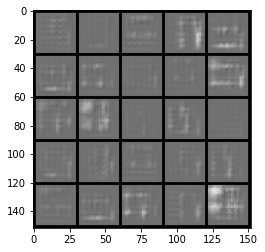

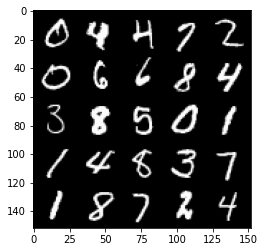

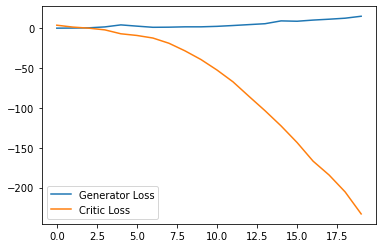

Step 450: Generator loss: 10.037680411338807, critic loss: -249.27249481201176


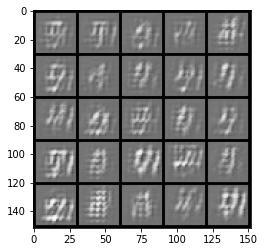

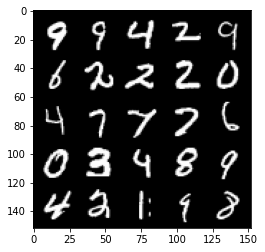

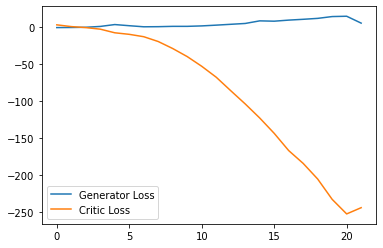

Step 500: Generator loss: -2.6413537138700485, critic loss: -248.52283637237542


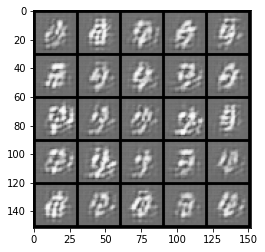

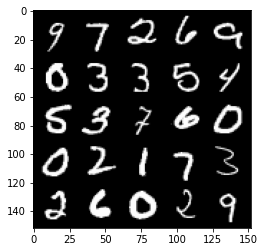

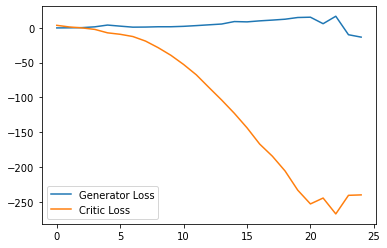

Step 550: Generator loss: 23.151933000087737, critic loss: -327.6246170959472


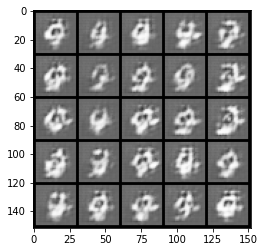

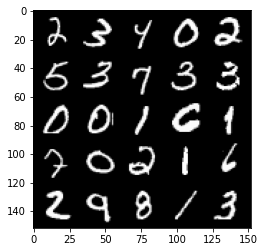

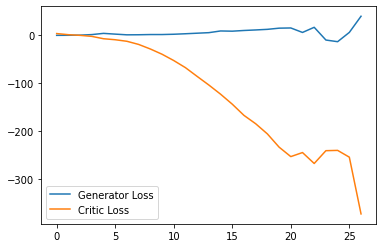

Step 600: Generator loss: 10.046043856143951, critic loss: -370.3437055664063


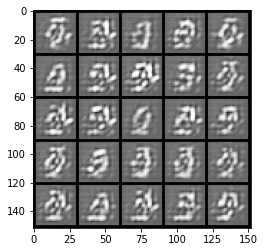

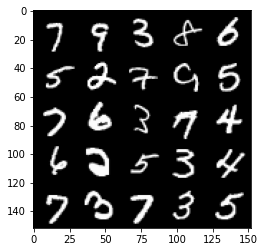

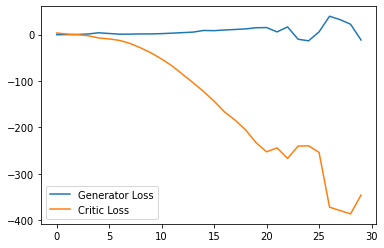

Step 650: Generator loss: -16.978251427412033, critic loss: -314.15437089538585


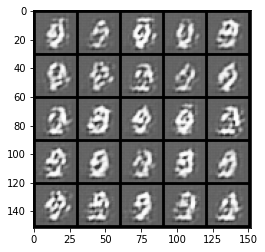

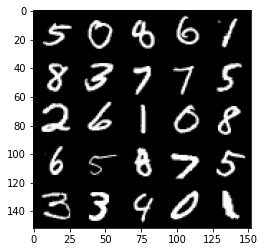

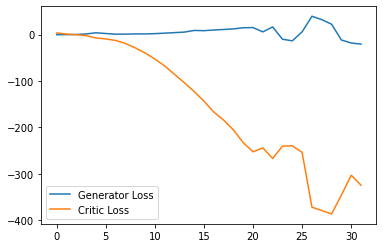

Step 700: Generator loss: 22.019518830776214, critic loss: -382.6794679260254


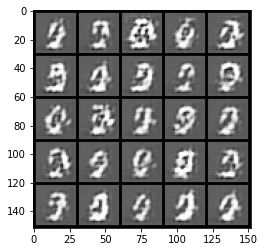

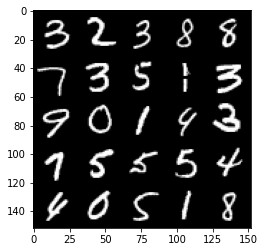

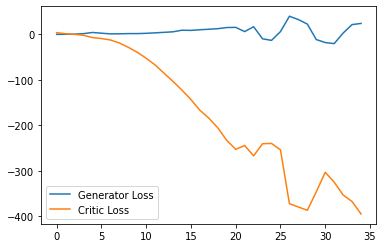

Step 750: Generator loss: 14.150717537999153, critic loss: -335.3066388854981


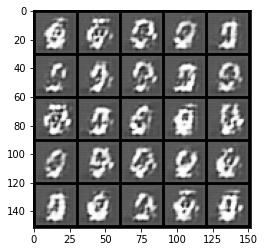

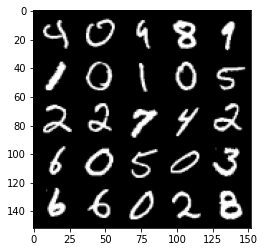

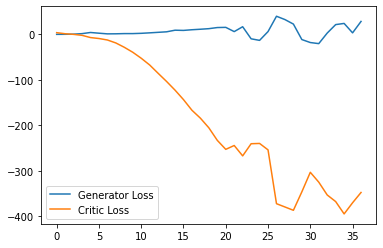

Step 800: Generator loss: -20.476694440841676, critic loss: -275.60436555480965


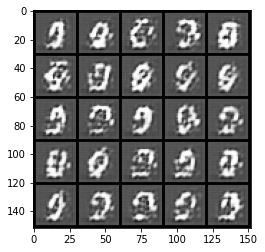

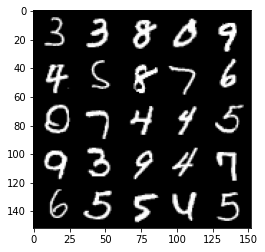

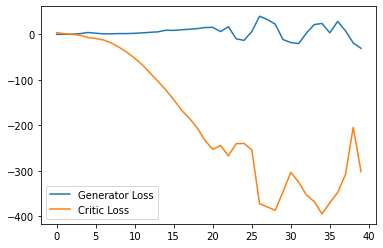

Step 850: Generator loss: -28.863535423278808, critic loss: -292.2344627990722


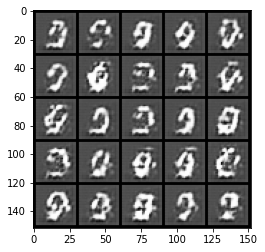

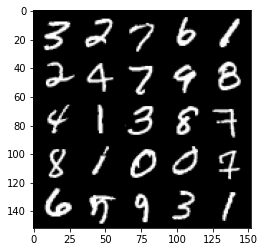

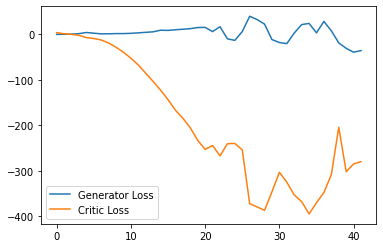

Step 900: Generator loss: -39.76112509727478, critic loss: -225.4697550201416


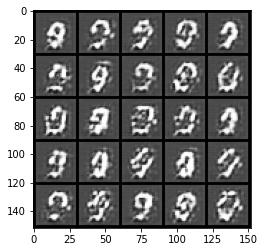

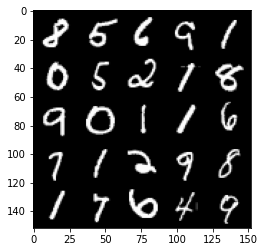

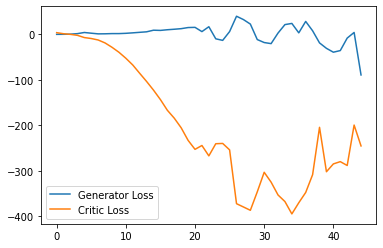

Step 950: Generator loss: -70.37741735696792, critic loss: -236.9494006423951


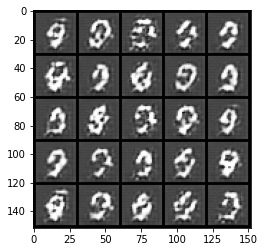

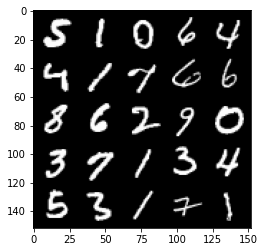

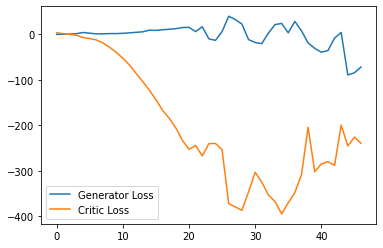

Step 1000: Generator loss: -48.531783447265624, critic loss: -229.9483578796387


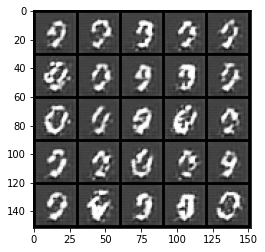

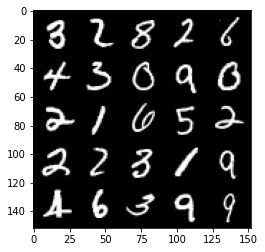

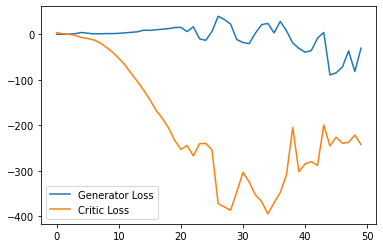

Step 1050: Generator loss: -19.84509072303772, critic loss: -190.4213817138672


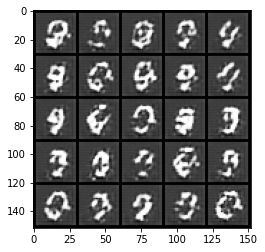

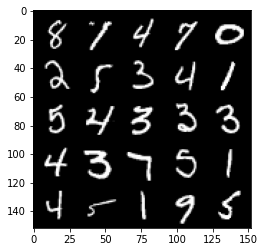

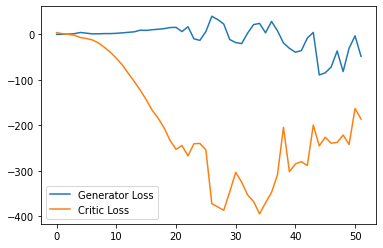

Step 1100: Generator loss: 13.196950340270996, critic loss: 34.71863500976562


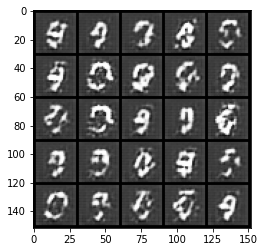

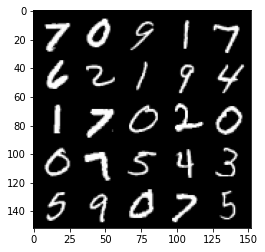

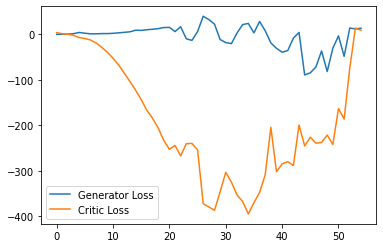

Step 1150: Generator loss: -26.2412233877182, critic loss: -80.76454602050782


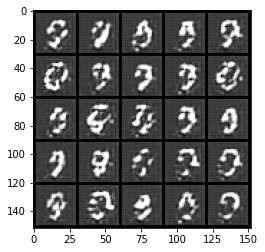

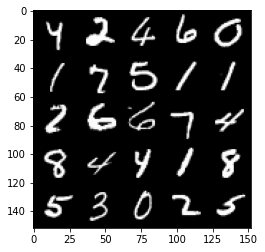

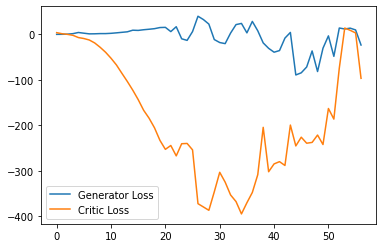

Step 1200: Generator loss: -27.241319777965547, critic loss: -143.49215727996832


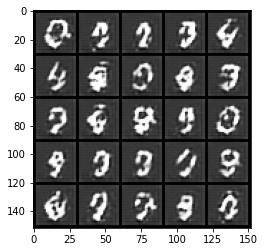

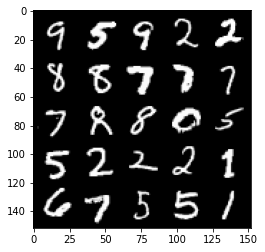

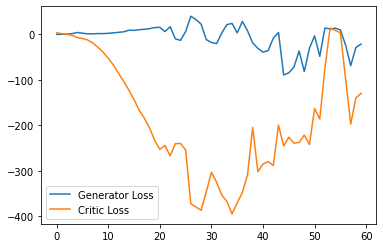

Step 1250: Generator loss: -13.258508574962615, critic loss: -65.8263073654175


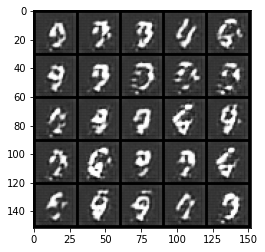

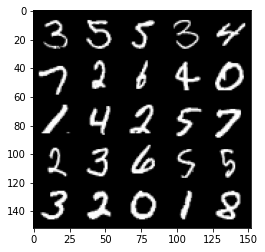

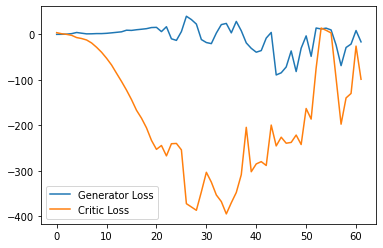

Step 1300: Generator loss: -3.6799569511413575, critic loss: -14.293032413482667


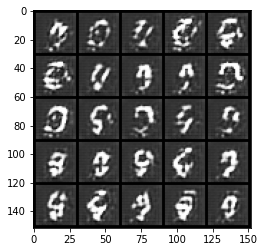

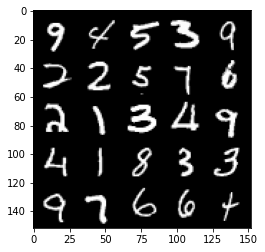

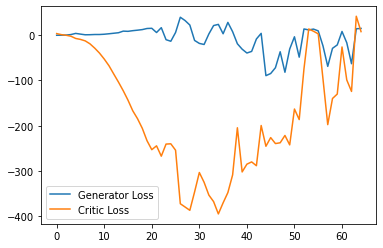

Step 1350: Generator loss: -42.16878196001053, critic loss: -102.21047592163087


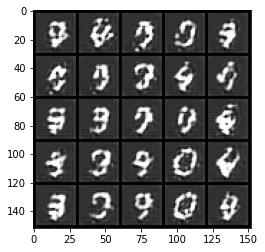

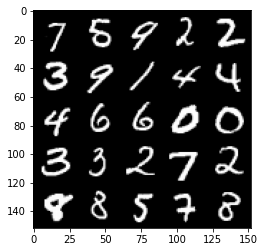

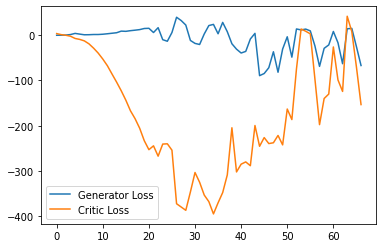

Step 1400: Generator loss: -65.02823992729186, critic loss: -138.2420177001953


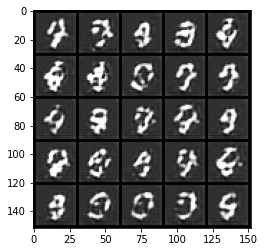

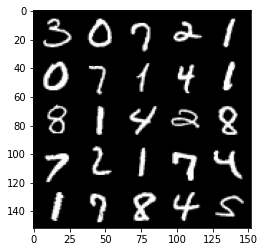

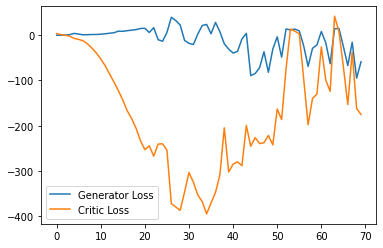

Step 1450: Generator loss: -2.3881428730487824, critic loss: 121.28348898315427


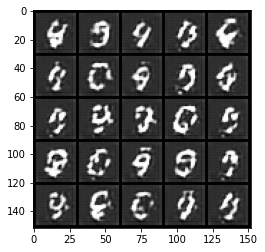

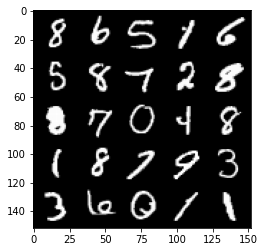

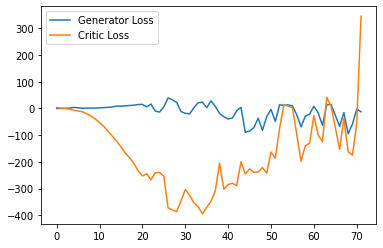

Step 1500: Generator loss: 8.64476881980896, critic loss: 9.373315750122071


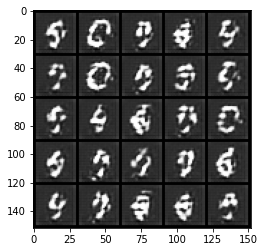

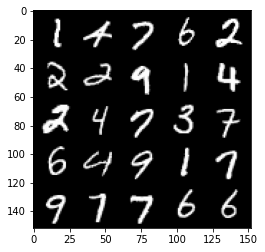

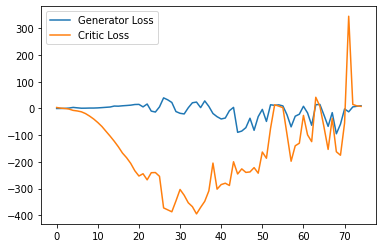

Step 1550: Generator loss: 10.606323165893555, critic loss: 12.30105591773987


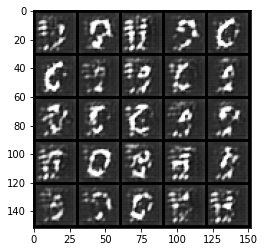

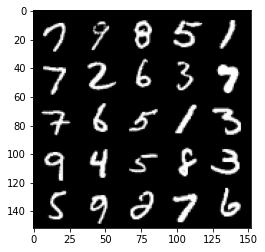

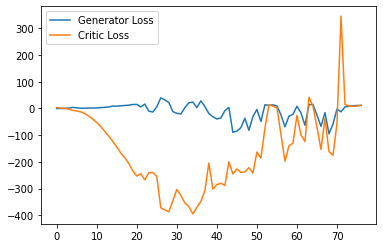

Step 1600: Generator loss: 7.735995473861695, critic loss: 34.262439952850336


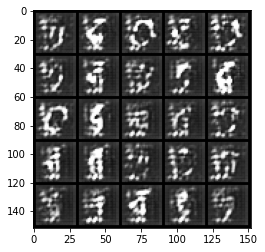

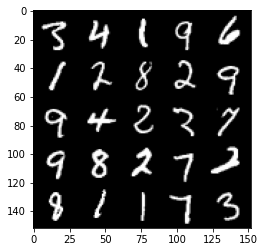

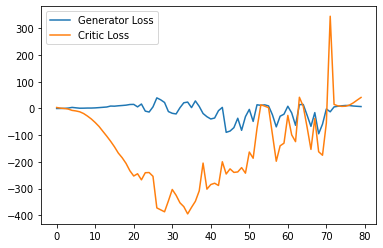

Step 1650: Generator loss: 5.501163268089295, critic loss: 58.08793732452392


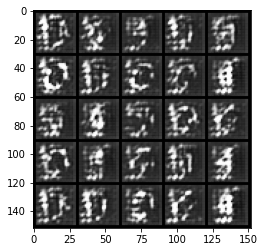

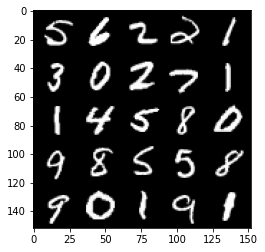

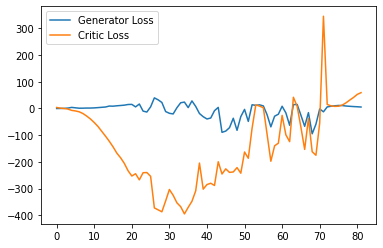

Step 1700: Generator loss: 2.9848352217674257, critic loss: 72.75555395507813


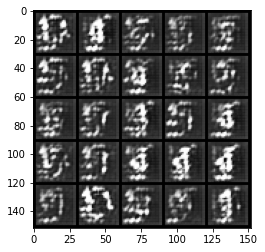

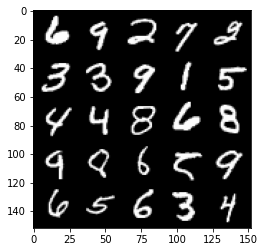

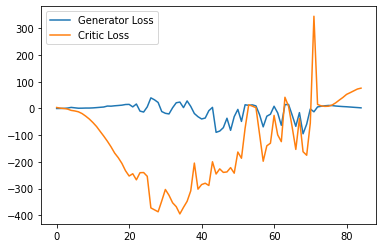

Step 1750: Generator loss: 0.38690175861120224, critic loss: 83.02619784545901


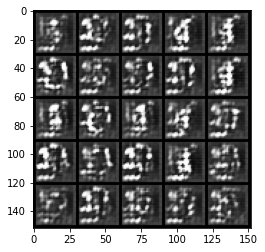

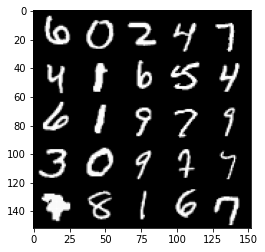

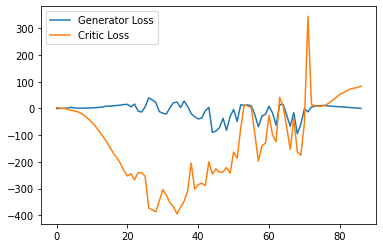

Step 1800: Generator loss: -4.577925047874451, critic loss: 108.69016691589356


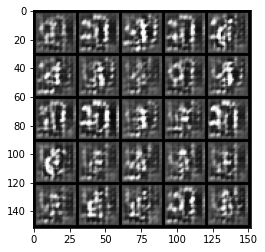

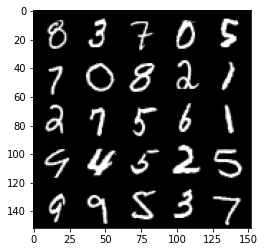

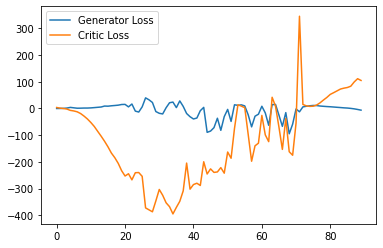

Step 1850: Generator loss: -7.709111671447754, critic loss: 86.27160031127929


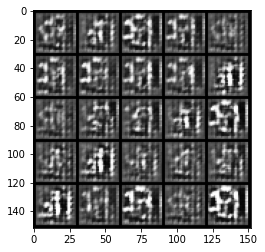

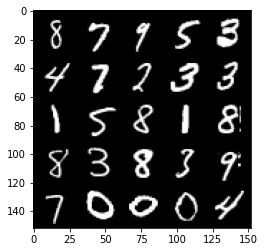

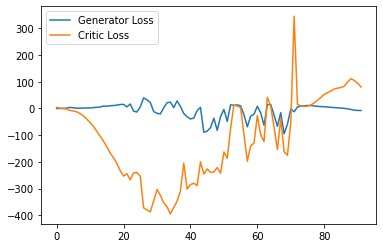

Step 1900: Generator loss: -11.94684715270996, critic loss: 84.05235385131837


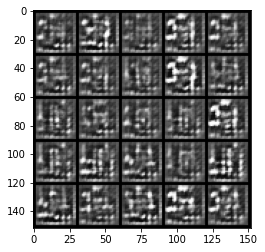

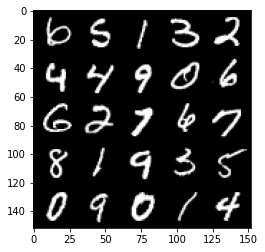

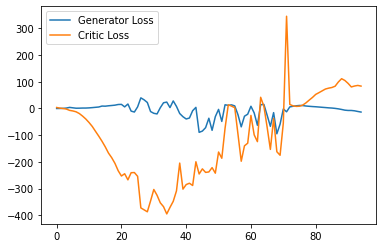

Step 1950: Generator loss: -11.41296257019043, critic loss: 63.048930664062475


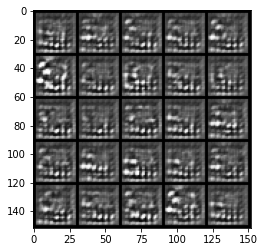

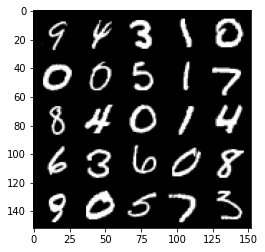

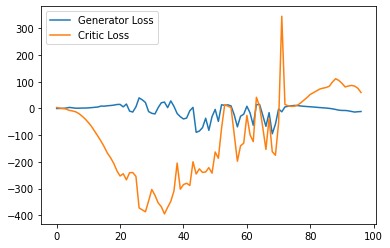

Step 2000: Generator loss: -5.9506936812400815, critic loss: 22.173739845275875


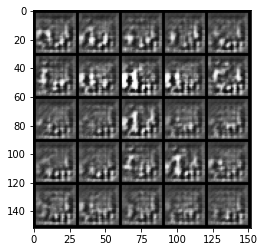

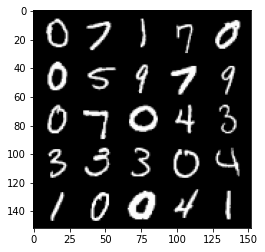

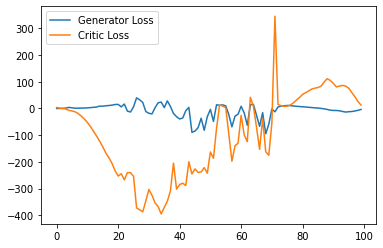

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

           
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
          
            crit_loss.backward(retain_graph=True)
            
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        
        gen_opt.step()

       
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
